In [1]:
from multigrids import TemporalGrid, TemporalMultiGrid
import joblib
import sys
import os
sys.path.insert(0, os.path.abspath('../forestpy/forestpy'))

import forest
from importlib import reload
reload(forest)
import random_forest_tools as tools
reload(tools)

import matplotlib.pyplot as plt

In [2]:
sp_tki = TemporalGrid('/Users/rwspicer/Desktop/data/V1/thermokarst/initiation-regions/SP/v1/PDM-5var/without_predisp/multigrid/SP-TKI-PDM5.yml')

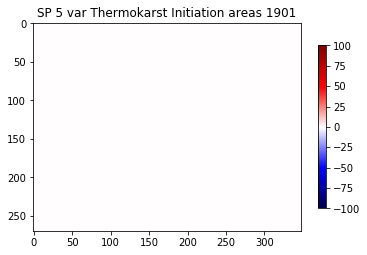

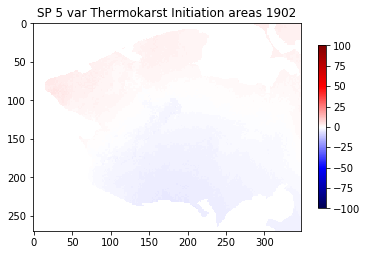

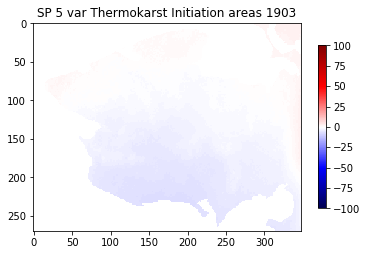

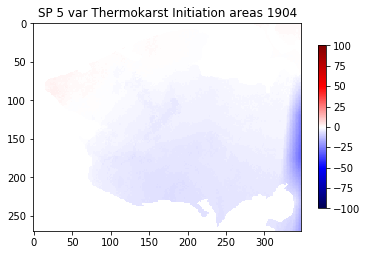

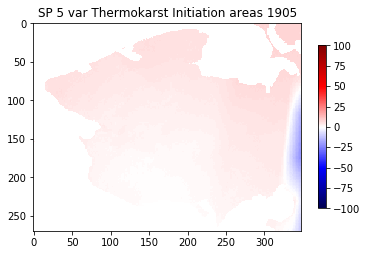

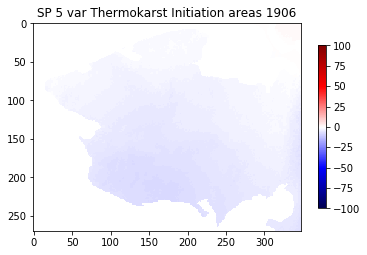

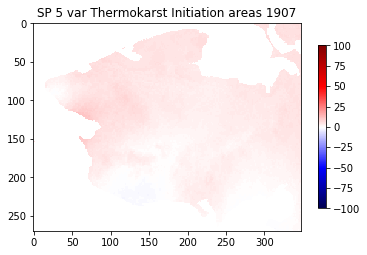

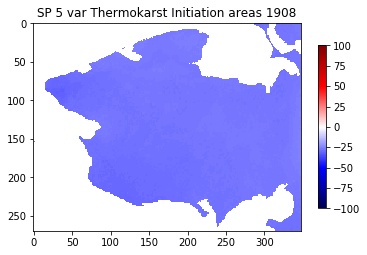

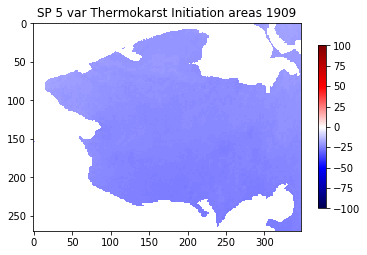

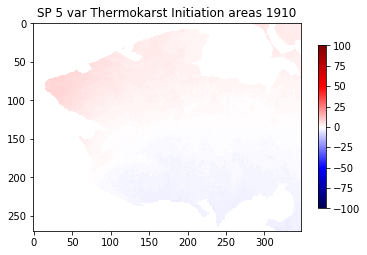

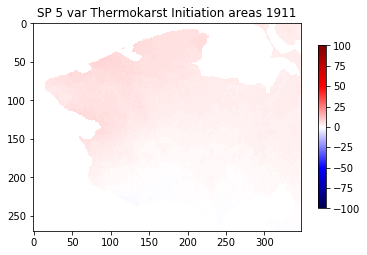

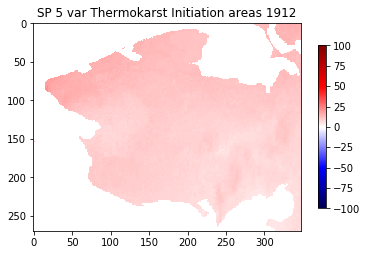

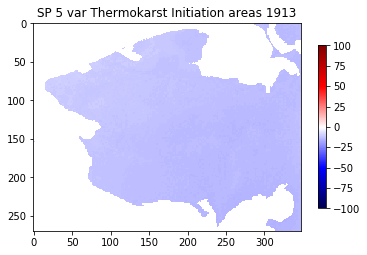

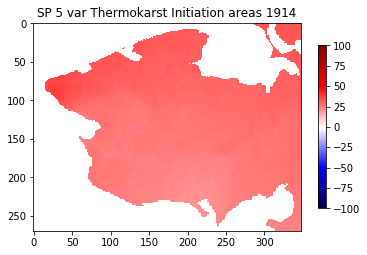

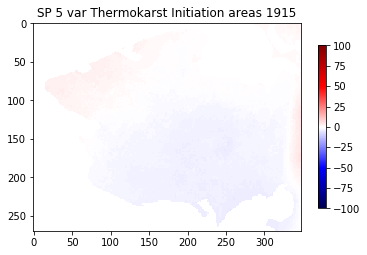

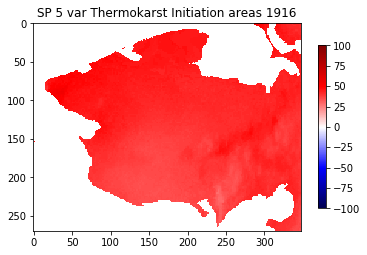

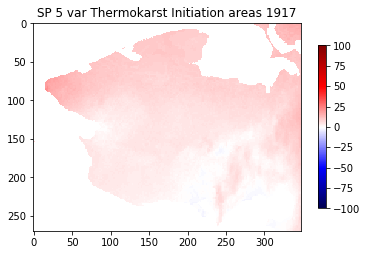

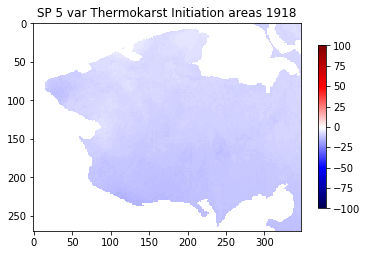

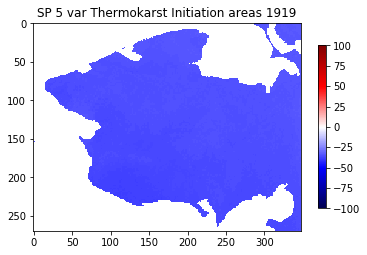

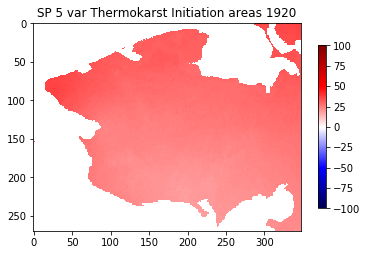

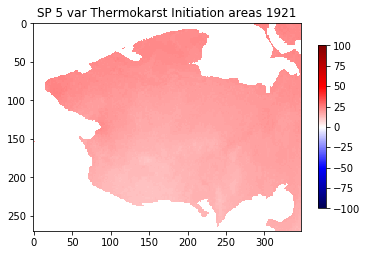

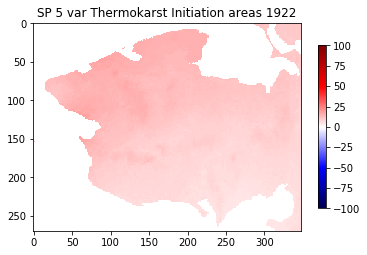

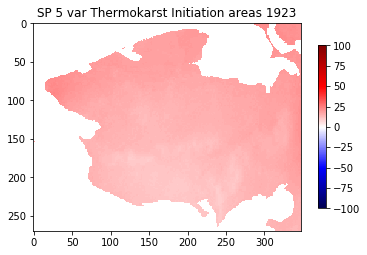

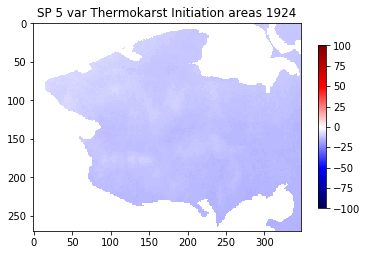

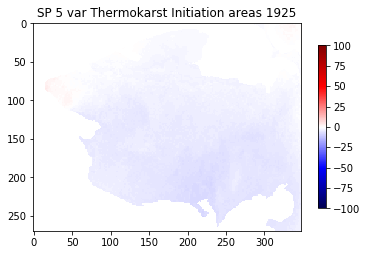

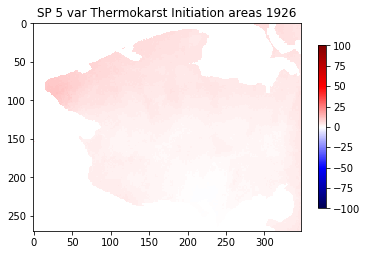

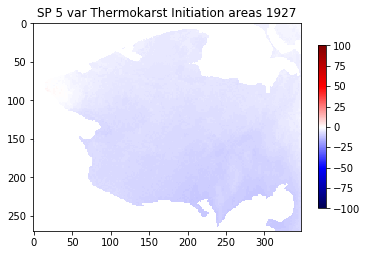

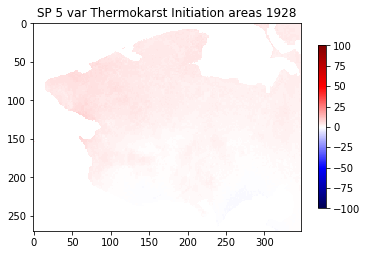

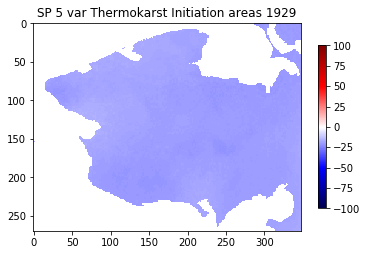

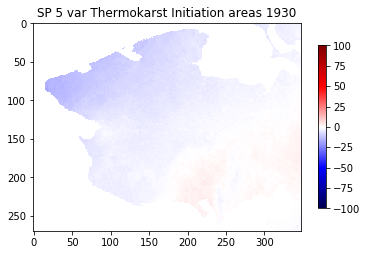

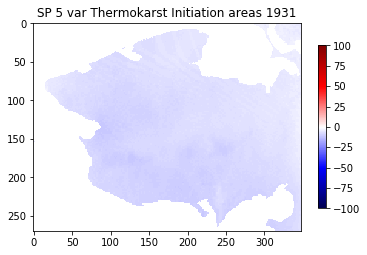

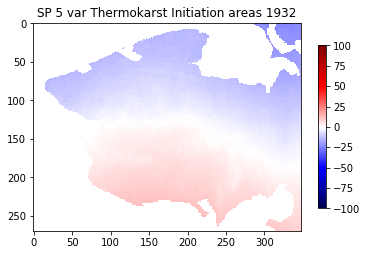

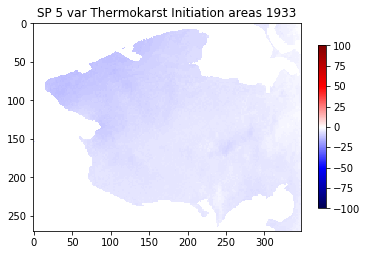

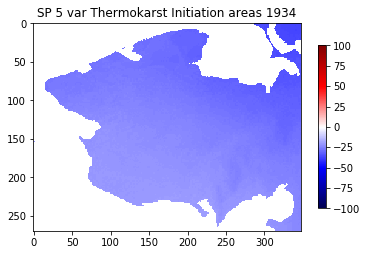

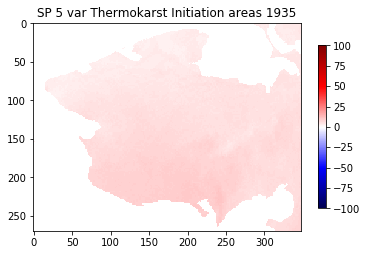

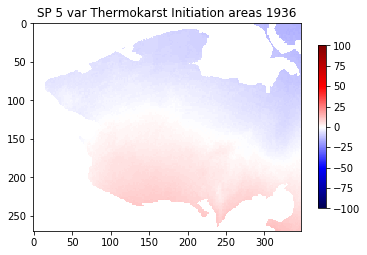

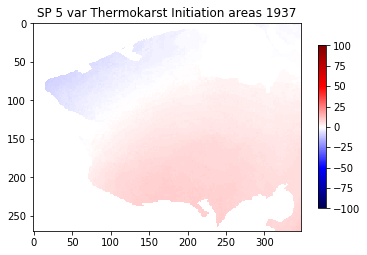

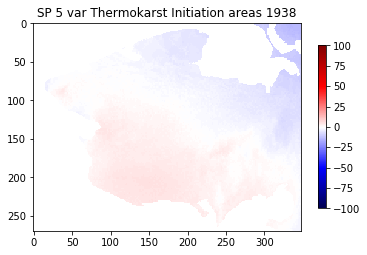

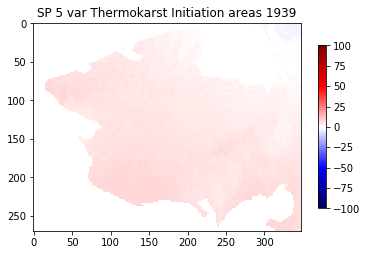

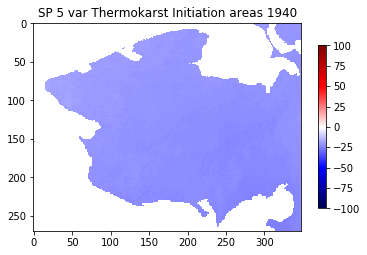

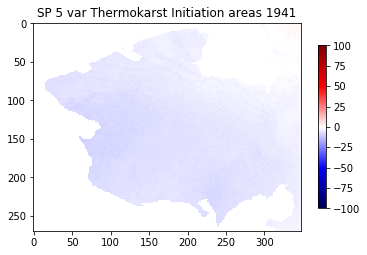

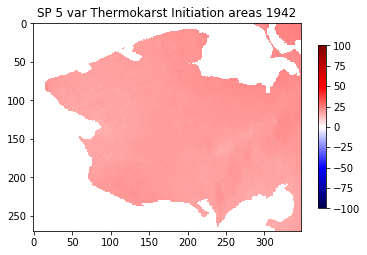

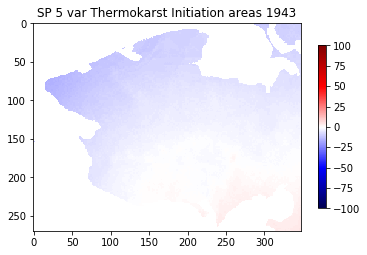

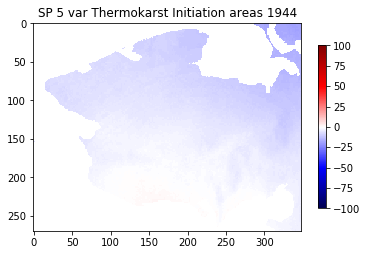

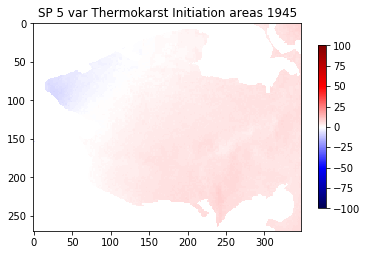

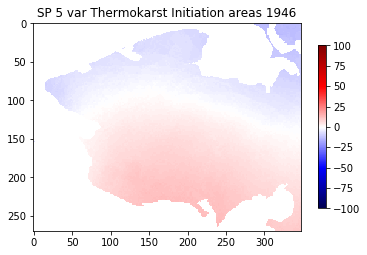

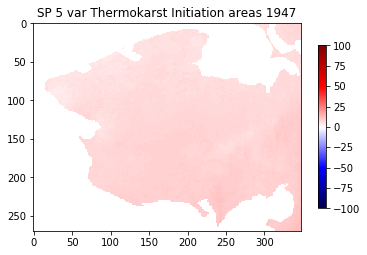

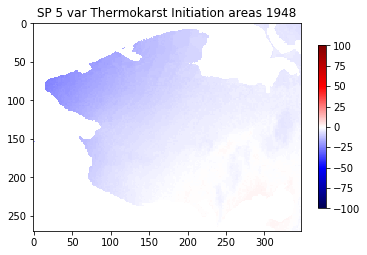

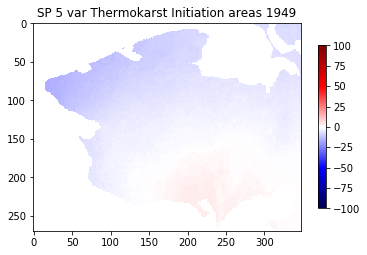

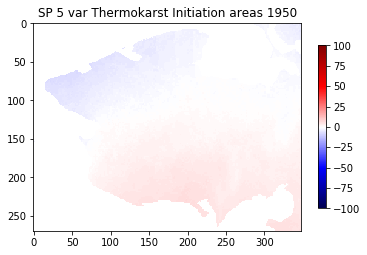

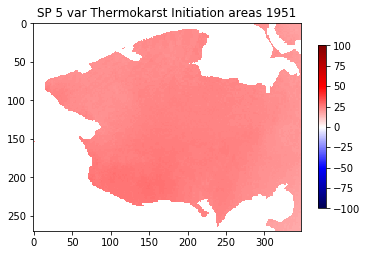

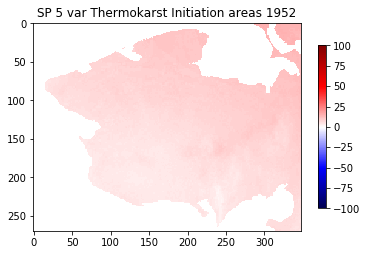

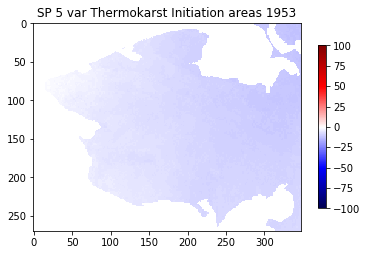

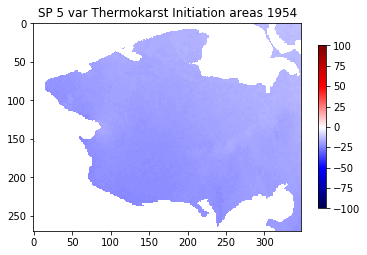

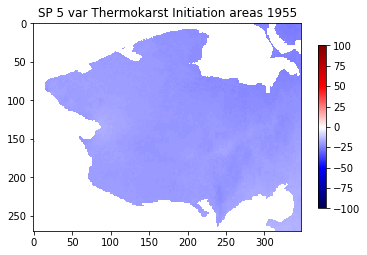

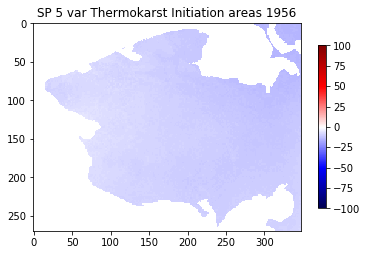

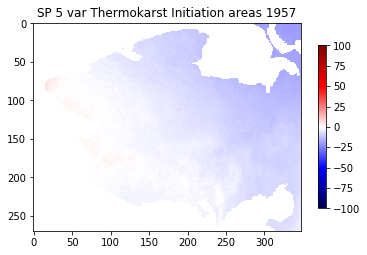

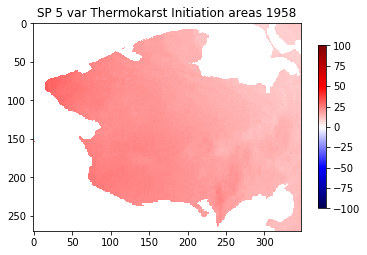

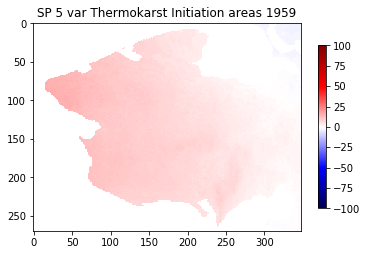

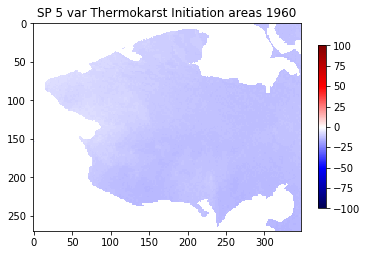

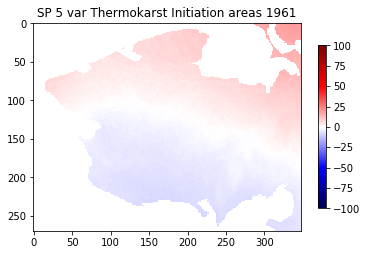

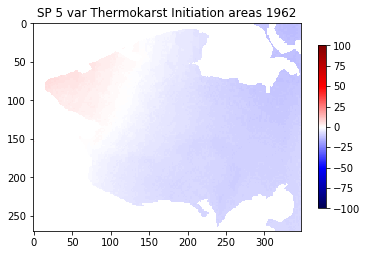

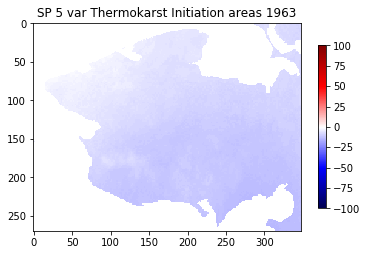

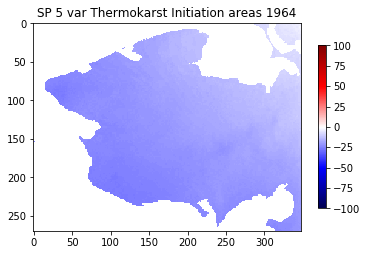

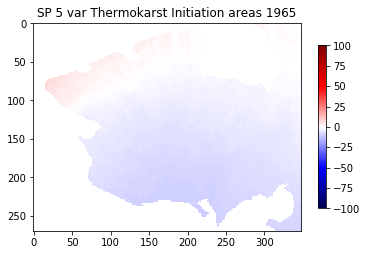

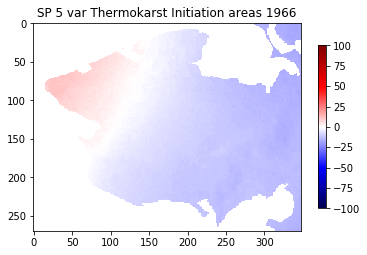

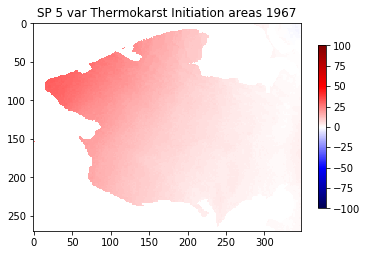

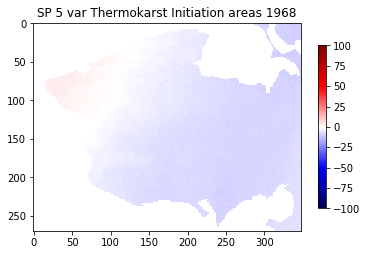

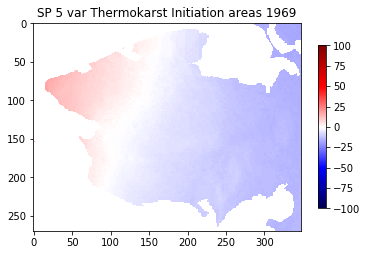

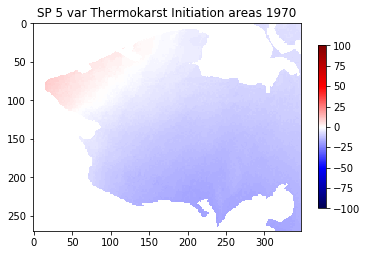

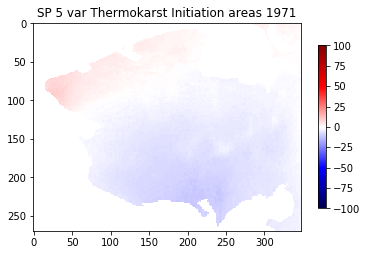

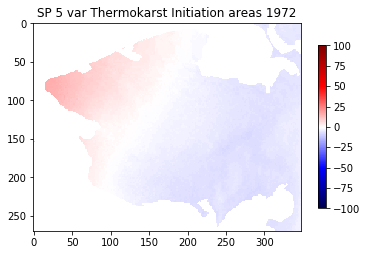

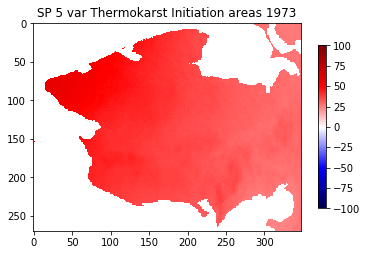

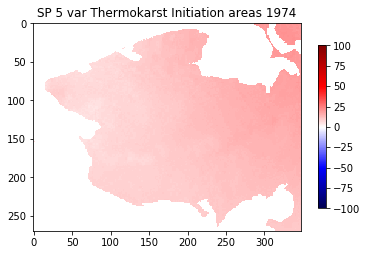

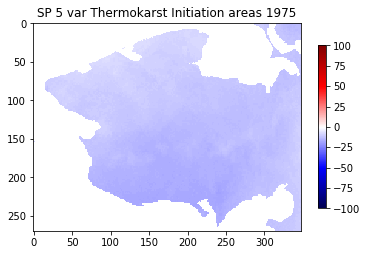

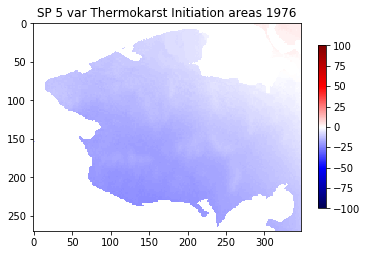

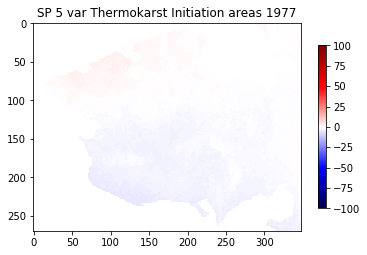

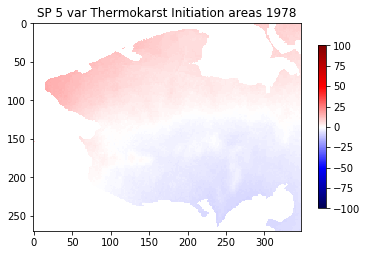

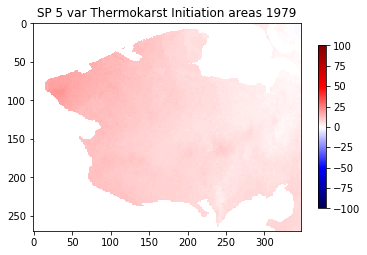

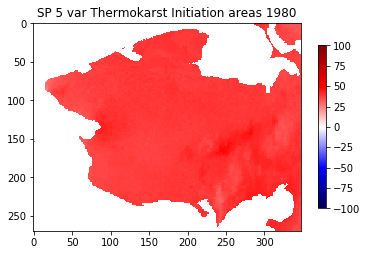

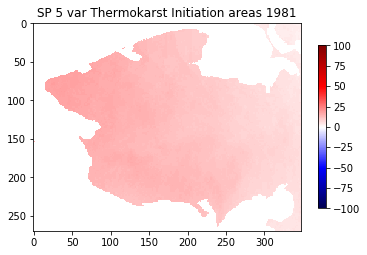

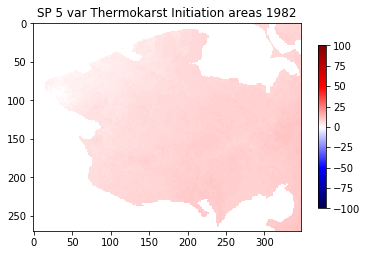

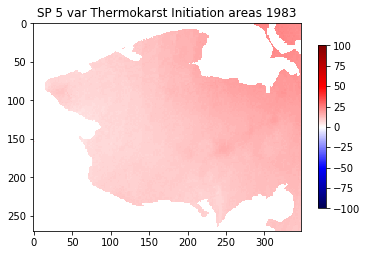

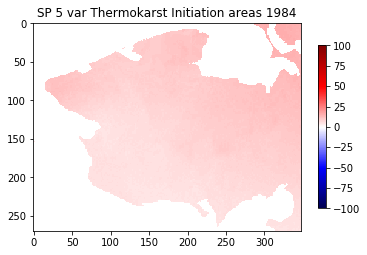

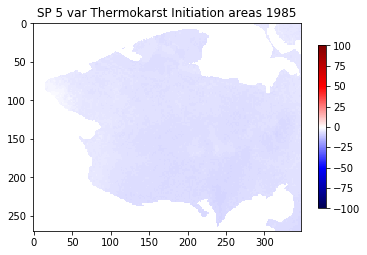

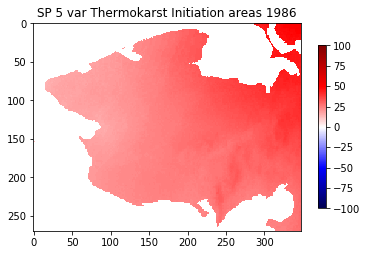

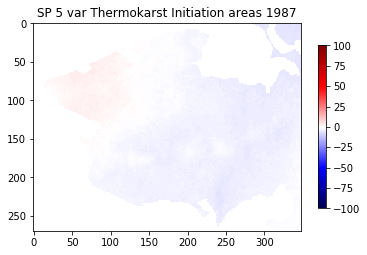

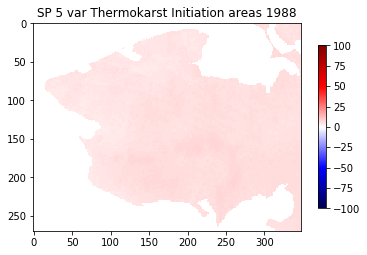

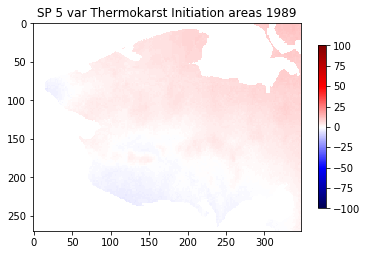

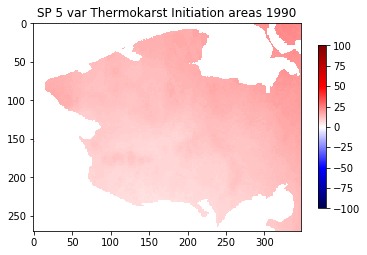

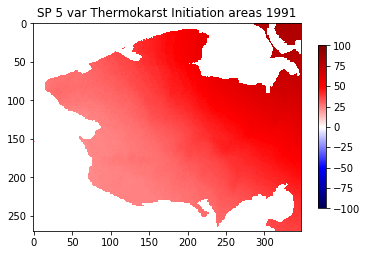

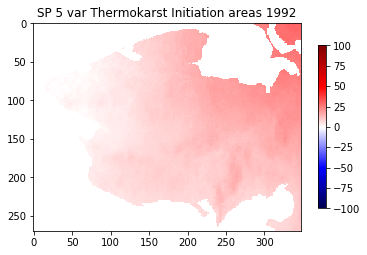

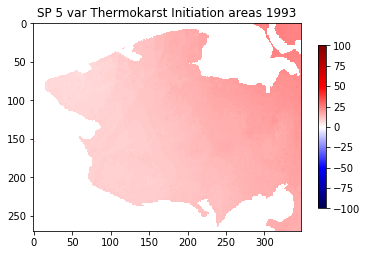

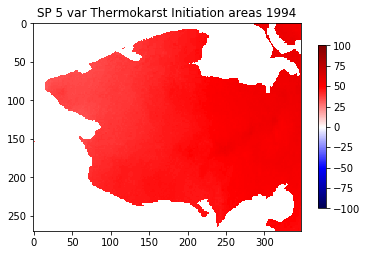

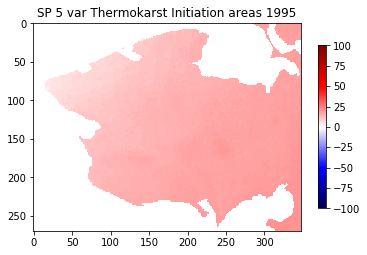

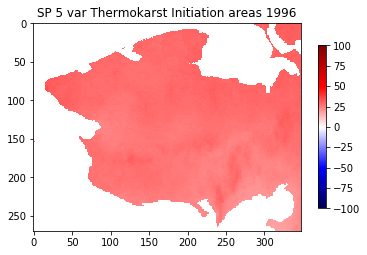

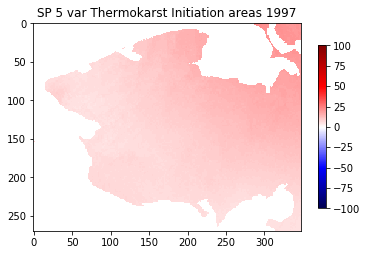

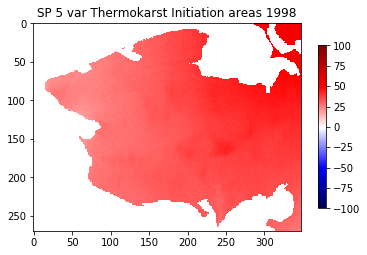

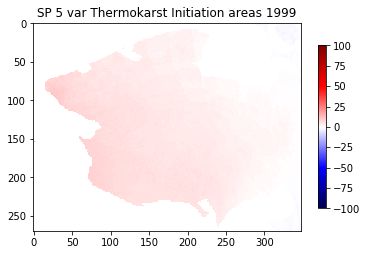

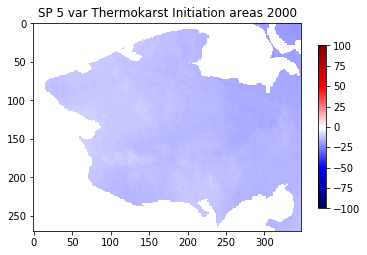

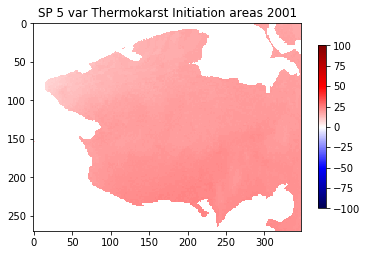

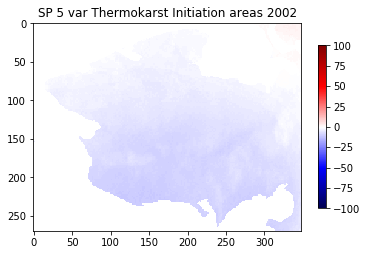

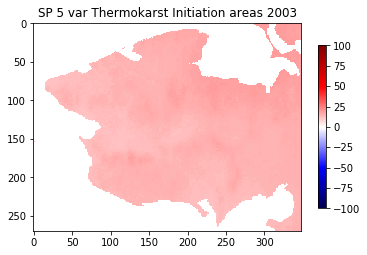

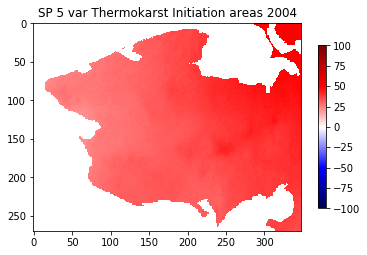

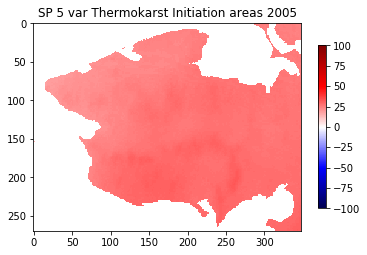

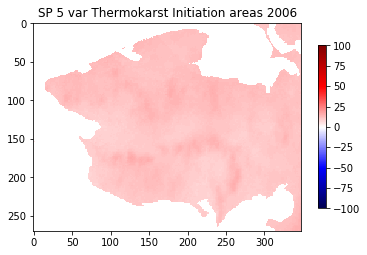

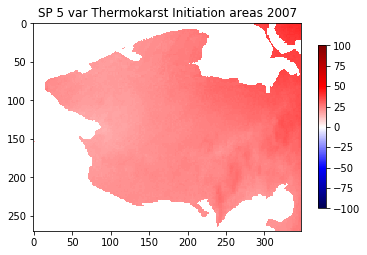

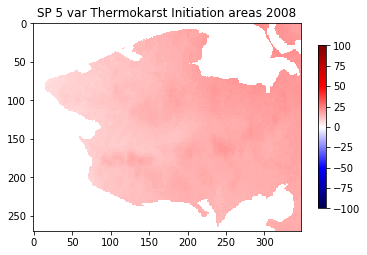

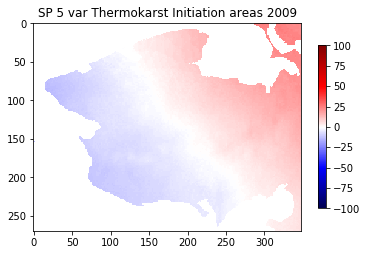

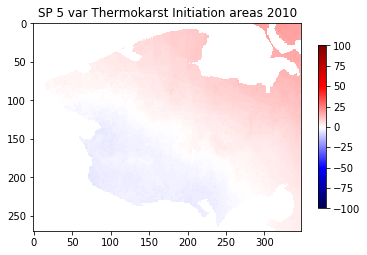

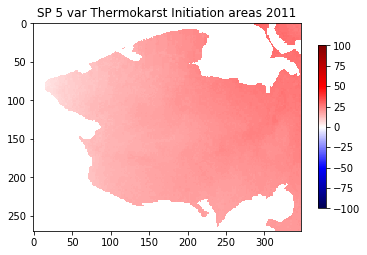

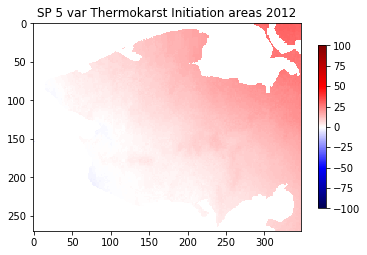

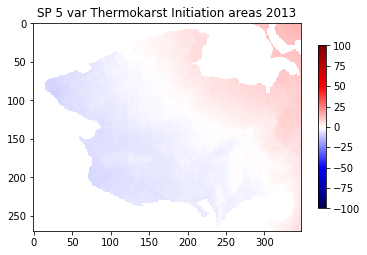

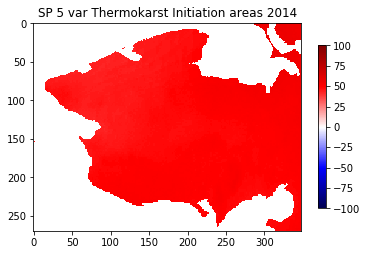

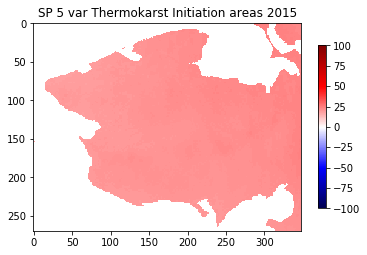

In [3]:
for y in range(1901,2016):
    sp_tki.show_figure(y, figure_args={'vmin': -100, 'vmax':100, 'cmap': 'seismic' })

In [36]:
sp_tki.save_clip('SP-TKI.mp4', clip_args={'figure_args':{'title':'Thermokarst Initation Seward Pen', 'vmin': -100, 'vmax':100, 'cmap': 'seismic'} })

t:   2%|▏         | 2/115 [00:00<00:06, 18.24it/s, now=None]

Moviepy - Building video SP-TKI.mp4.
Moviepy - Writing video SP-TKI.mp4



Moviepy - Done !
Moviepy - video ready SP-TKI.mp4


True

In [38]:
sp_feats =  TemporalMultiGrid('/Users/rwspicer/Desktop/data/V1/master-project/training/SP/v1/baseline/multigrid/SP-rf-training-set.yml')

In [40]:
model = joblib.load('../baseline-models/rfm_e10_md100_mfAUTO_mln50000_msl4_mss10_tdp50.joblib')

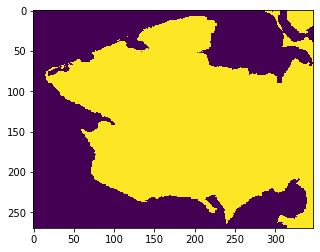

In [67]:
import numpy as np
mask = np.logical_not(np.isnan(sp_feats['fdd', 1950]))
for k in sp_feats.config['grid_name_map']:
    mask = np.logical_and(mask, np.logical_not(np.isnan(sp_feats[k, 1950]) ))
mask = np.logical_and(mask, np.logical_not(np.isnan(sp_tki[1950]) ))
plt.imshow(mask)

In [68]:
feats= sp_feats.get_as_ml_features(mask=mask)

/Users/rwspicer/miniconda3/envs/atm-env3/lib/python3.7/site-packages/numpy/core/memmap.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  res = super(memmap, self).__getitem__(index)


In [69]:
labels = sp_tki.get_as_ml_features(None,mask=mask)

In [70]:
feats.shape, labels.shape

((13, 6231275), (6231275,))

In [71]:
model.score(feats.T, labels)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.5s finished


-0.3609661616134243

In [105]:
sp_feats.config['mask'] = mask
training_data = sp_feats

def evaulte_model_statistically(model_file, om, year, mask, model_name = ''):
    """
    """
    
    if type(model_file) is str:
        clf = joblib.load(model_file)
    else: 
        clf = model_file
        
    ov = clf.verbose
    clf.verbose = 0 
    new = tools.apply_model_to_year(clf, training_data, year, mask)

#     tools.quick_coolwarm(om[year] , 'original model ' + str(year))
#     tools.quick_coolwarm(new , model_name + ' '+ str(year))

    r2 = clf.score(feats.T,labels)
    
    diff = (new -om[year])
#     tools.to_figure(diff , '',  'comparison ' + str(year),cmap = 'coolwarm', vmin=-10,vmax=10, save=False)

    stats = {
        'min diff': np.nanmin(diff), 
        'max diff': np.nanmax(diff),
        'mean diff': np.nanmean(diff),
        'abs mean diff': np.nanmean(np.abs(diff)),
        'max abs diff': np.nanmax(np.abs(diff)),
        'min abs diff': np.nanmin(np.abs(diff)),
        'min predict':np.nanmin(new),
        'max predict':np.nanmax(new), 
        'r^2': r2
    }
    clf.verbose = ov
    return stats

def evaulte_model_pictorially(model_file, om, year, mask, model_name = '' ):
    """
    """
    import pprint
    if type(model_file) is str:
        clf = joblib.load(model_file)
    else: 
        clf = model_file
        
    ov = clf.verbose
    clf.verbose = 0
    new = tools.apply_model_to_year(clf, training_data, year, mask)

#     tools.quick_coolwarm(om[year] , 'original model ' + str(year))
#     tools.quick_coolwarm(new , model_name + ' '+ str(year))

    tools.to_figure(om[year] ,'', 'original model ' + str(year),cmap = 'coolwarm', vmin=-100,vmax=100, save=False)
    tools.to_figure(new , '',model_name + ' '+ str(year),cmap = 'coolwarm', vmin=-100,vmax=100, save=False)



    
    diff = (new -om[year])
    tools.to_figure(diff , '',  'comparison ' + str(year),cmap = 'coolwarm', save=False)

    stats = evaulte_model_statistically(clf, om, year, mask, model_name)
    pprint.pprint(stats)
    
#     print ('min diff:', np.nanmin(diff), 'max diff:', np.nanmax(diff))
#     print ('mean diff:', np.nanmean(diff), 'abs mean diff:', np.nanmean(np.abs(diff)))
    clf.verbose = ov
    return clf

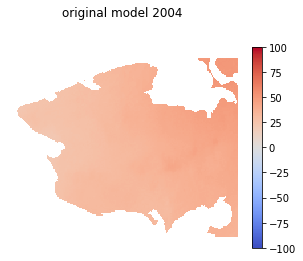

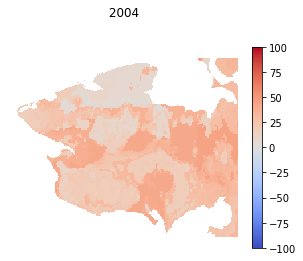

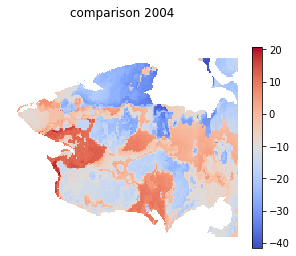

{'abs mean diff': 12.453619495680957,
 'max abs diff': 41.632938772687396,
 'max diff': 20.708590662032172,
 'max predict': 47.28027814491357,
 'mean diff': -9.430854566760917,
 'min abs diff': 0.00017456820463479517,
 'min diff': -41.632938772687396,
 'min predict': 0.4923285259206562,
 'r^2': -0.29308542359792633}


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='auto', max_leaf_nodes=50000,
           min_impurity_decrease=0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=5,
           min_weight_fraction_leaf=0, n_estimators=100, n_jobs=4,
           oob_score=False, random_state=42, verbose=2, warm_start=False)

In [106]:
evaulte_model_pictorially('../baseline-models/rfm_e100_md25_mfAUTO_mln50000_msl2_mss5_tdp25.joblib', sp_tki, 2004, mask)